# old stuff

Import packages.
If you don't have a certain package, e.g. 'newpackage', just type  
`pip install newpackage`

In [1]:
import urllib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os.path
import matplotlib.dates as mdates
import datetime as dt
import matplotlib as mpl
from pandas.tseries.frequencies import to_offset
from scipy.signal import savgol_filter

This is how you download data from Thingspeak

In [2]:
filename1 = "test_elad.csv"
# if file is not there, go fetch it from thingspeak
if not os.path.isfile(filename1):
    # define what to download
    channels = "1690490"
    fields = "1,2,3,4,6,7"
    minutes = "30"

    # https://www.mathworks.com/help/thingspeak/readdata.html
    # format YYYY-MM-DD%20HH:NN:SS
    start = "2022-05-01%2000:00:00"
    end = "2022-05-08%2000:00:00"

    # download using Thingspeak's API
    # url = f"https://api.thingspeak.com/channels/{channels}/fields/{fields}.csv?minutes={minutes}"
    url = f"https://api.thingspeak.com/channels/{channels}/fields/{fields}.csv?start={start}&end={end}"
    data = urllib.request.urlopen(url)
    d = data.read()

    # save data to csv
    file = open(filename1, "w")
    file.write(d.decode('UTF-8'))
    file.close()


You can load the data using Pandas. Here we create a "dataframe", which is a fancy name for a table.

In [3]:
# load data
df = pd.read_csv(filename1)
# rename columns
df = df.rename(columns={"created_at": "timestamp",
                        "field1": "T1",
                        "field2": "RH",
                        "field3": "T2",
                        "field4": "motion_sensor",
                        "field6": "VWC",
                        "field7": "VPD",})
# set timestamp as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')


### First graph

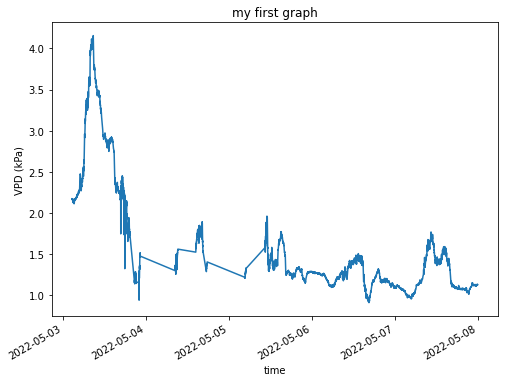

In [4]:
# %matplotlib widget

fig, ax = plt.subplots(1, figsize=(8,6))

ax.plot(df['VPD'])
# add labels and title
ax.set(xlabel = "time",
       ylabel = "VPD (kPa)",
       title = "my first graph")
# makes slanted dates
plt.gcf().autofmt_xdate()  


### Two columns in the same graph

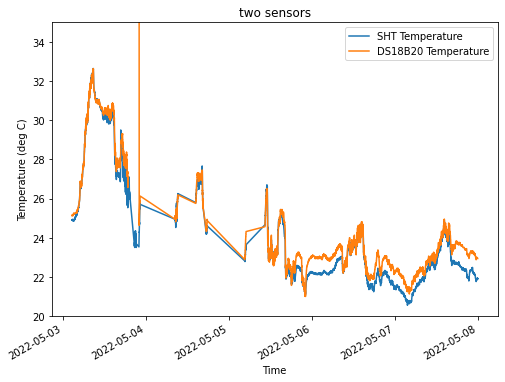

In [5]:
# %matplotlib widget

fig, ax = plt.subplots(1, figsize=(8,6))

ax.plot(df['T1'], color="tab:blue", label="SHT Temperature")
ax.plot(df['T2'], color="tab:orange", label="DS18B20 Temperature")
# add labels and title
ax.set(xlabel = "Time",
       ylabel = "Temperature (deg C)",
       title = "two sensors",
       ylim=[20,35],
       )
# makes slanted dates
plt.gcf().autofmt_xdate()
ax.legend(loc="upper right")

### Calculate stuff

You can calculate new things and save them as new columns of your dataframe.

In [6]:
def calculate_es(T):
    es = np.exp((16.78 * T - 116.9) / (T + 237.3))
    return es

def calculate_ed(es, rh):
    return es * rh / 100.0

es = calculate_es(df['T1'])
ed = calculate_ed(es, df['RH'])
df['VPD2'] = es - ed

See if what you calculated makes sense.

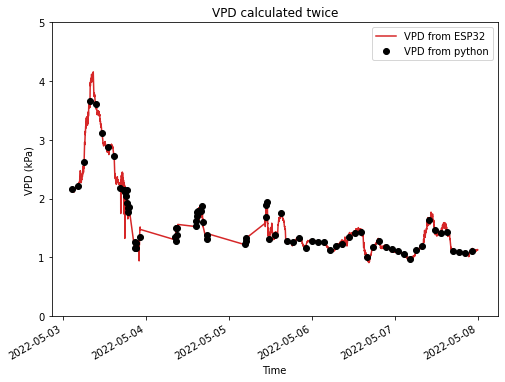

In [7]:
# %matplotlib widget

fig, ax = plt.subplots(1, figsize=(8,6))

ax.plot(df['VPD'], color="tab:red", label="VPD from ESP32")
ax.plot(df['VPD2'][::100], "o", color="black", label="VPD from python")
# add labels and title
ax.set(xlabel = "Time",
       ylabel = "VPD (kPa)",
       title = "VPD calculated twice",
       ylim=[0,5],
       )
# makes slanted dates
plt.gcf().autofmt_xdate()
ax.legend(loc="upper right")

### Two y axes

Text(0, 0.5, 'Temperature (deg C)')

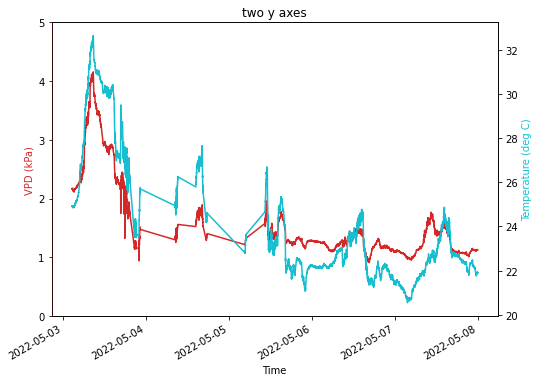

In [8]:
# %matplotlib widget

fig, ax = plt.subplots(1, figsize=(8,6))

ax.plot(df['VPD'], color="tab:red", label="VPD")
plt.gcf().autofmt_xdate()
ax2 = ax.twinx()
ax2.plot(df['T1'], color="tab:cyan", label="Temperature")
ax.set(xlabel = "Time",
       title = "two y axes",
       ylim=[0,5],
       )
ax.set_ylabel('VPD (kPa)', color='tab:red')
ax.spines['left'].set_color('red')

ax2.set_ylabel('Temperature (deg C)', color='tab:cyan')

## NaN, Missing data, Outliers

[Text(0.5, 0, ''), Text(0, 0.5, 'Temperature (deg C)')]

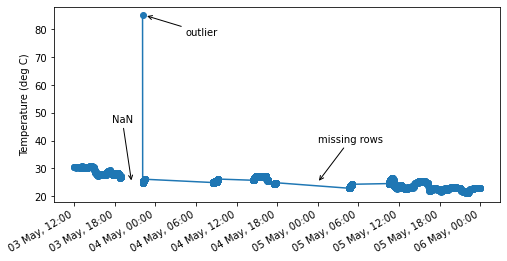

In [9]:
# %matplotlib widget

start = "2022-05-03 12:00:00"
end = "2022-05-06 00:00:00"

fig, ax = plt.subplots(1, figsize=(8,4))

# plot using pandas' plot method
df.loc[start:end, 'T2'].plot(ax=ax,
                             linestyle='-',
                             marker='o',
                             color="tab:blue",
                             label="data")

# annotate examples here:
# https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.html
ax.annotate("NaN",                             # text to write, if nothing, then ""
            xy=('2022-05-03 20:30:00', 25),    # (x,y coordinates for the tip of the arrow)
            xycoords='data',                   # xy as 'data' coordinates
            xytext=(-20, 60),                  # xy coordinates for the text
            textcoords='offset points',        # xytext relative to xy
            arrowprops=dict(arrowstyle="->")   # pretty arrow
           )
ax.annotate("outlier",
            xy=('2022-05-03 22:30:00', 85),
            xycoords='data',
            xytext=(40, -20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->")
           )
ax.annotate("missing rows",
            xy=('2022-05-05 00:00:00', 25),
            xycoords='data',
            xytext=(0, 40),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->")
           )

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b, %H:00'))
plt.gcf().autofmt_xdate()
ax.set(xlabel="",
       ylabel="Temperature (deg C)")

The arrows (annotate) work because the plot was  
`df['column'].plot()`  

If you use the usual  
`ax.plot(df['column'])`  
then you matplotlib will not understand timestamps as x-positions. In this case follow the instructions below.

[Text(0.5, 0, ''), Text(0, 0.5, 'Temperature (deg C)')]

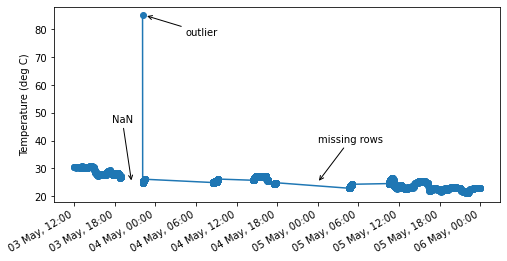

In [10]:
# %matplotlib widget

start = "2022-05-03 12:00:00"
end = "2022-05-06 00:00:00"

fig, ax = plt.subplots(1, figsize=(8,4))

ax.plot(df.loc[start:end, 'T2'], linestyle='-', marker='o', color="tab:blue", label="data")

t_nan = '2022-05-03 20:30:00'
x_nan = mdates.date2num(dt.datetime.strptime(t_nan, "%Y-%m-%d %H:%M:%S"))
ax.annotate("NaN",
            xy=(x_nan, 25),
            xycoords='data',
            xytext=(-20, 60),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->")
           )
t_outlier = '2022-05-03 22:30:00'
x_outlier = mdates.date2num(dt.datetime.strptime(t_outlier, "%Y-%m-%d %H:%M:%S"))
ax.annotate("outlier",
            xy=(x_outlier, 85),
            xycoords='data',
            xytext=(40, -20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->")
           )
t_missing = '2022-05-05 00:00:00'
x_missing = mdates.date2num(dt.datetime.strptime(t_missing, "%Y-%m-%d %H:%M:%S"))
ax.annotate("missing rows",
            xy=(x_missing, 25),
            xycoords='data',
            xytext=(0, 40),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->")
           )
# code for hours, days, etc
# https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b, %H:00'))
plt.gcf().autofmt_xdate()
ax.set(xlabel="",
       ylabel="Temperature (deg C)")

[(0.0, 100.0),
 Text(0.5, 0, 'running index'),
 Text(0, 0.5, '$\\Delta t$ (s)'),
 Text(0.5, 1.0, 'Time difference between consecutive rows')]

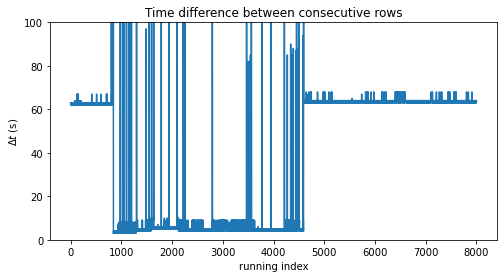

In [11]:
# %matplotlib widget

fig, ax = plt.subplots(1, figsize=(8,4))

delta_index = (df.index.to_series().diff() / pd.Timedelta('1 sec') ).values
ax.plot(delta_index)
ax.set(ylim=[0, 100],
       xlabel="running index",
       ylabel=r"$\Delta t$ (s)",
       title="Time difference between consecutive rows")

## Resample

### Downsampling

[Text(0.5, 0, 'time'), Text(0, 0.5, 'temperature (deg C)')]

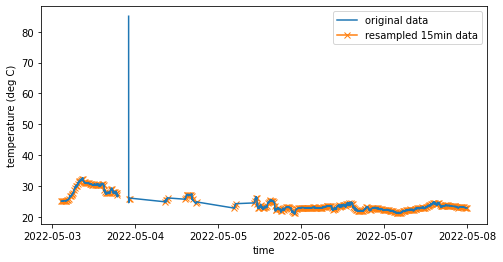

In [12]:
# %matplotlib widget

fig, ax = plt.subplots(1, figsize=(8,4))

# Downsample to spaced out data points. Change the number below, see what happens.
window_size = '15min'
df_resampled = (df['T2'].resample(window_size)  # resample doesn't do anything yet, just divides data into buckets
                        .mean()                 # this is where stuff happens. you can also choose "sum", "max", etc
               )
# optional, add half a window size to timestamp
df_resampled.index = df_resampled.index + to_offset(window_size) / 2

ax.plot(df['T2'], color="tab:blue", label="original data")
ax.plot(df_resampled, marker='x', color="tab:orange", zorder=-1,
        label=f"resampled {window_size} data")
ax.legend()

ax.set(xlabel="time",
       ylabel="temperature (deg C)")


### Filling missing data

[Text(0.5, 0, 'time'), Text(0, 0.5, 'temperature (deg C)')]

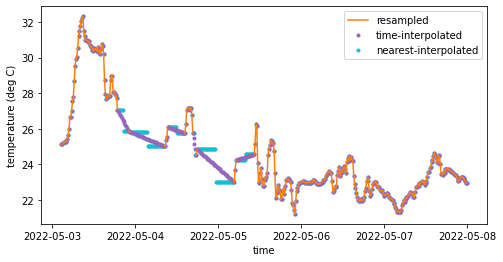

In [13]:
# %matplotlib widget

fig, ax = plt.subplots(1, figsize=(8,4))

# see options for interpolation methods here:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html
df_interpolated1 = df_resampled.interpolate(method='time')
df_interpolated2 = df_resampled.interpolate(method='nearest')

ax.plot(df_resampled, color="tab:orange", label="resampled")
ax.plot(df_interpolated1, '.', color="tab:purple", zorder=-1,
        label=f"time-interpolated")
ax.plot(df_interpolated2, '.', color="tab:cyan", zorder=-2,
        label=f"nearest-interpolated")
ax.legend()

ax.set(xlabel="time",
       ylabel="temperature (deg C)")

## Smoothing noisy data

Let's first download data from a different project.

In [14]:
filename2 = "test_peleg.csv"
# if file is not there, go fetch it from thingspeak
if not os.path.isfile(filename2):
    # define what to download
    channels = "1708067"
    fields = "1,2,3,4,5"
    minutes = "30"

    # https://www.mathworks.com/help/thingspeak/readdata.html
    # format YYYY-MM-DD%20HH:NN:SS
    start = "2022-05-15%2000:00:00"
    end = "2022-05-25%2000:00:00"

    # download using Thingspeak's API
    # url = f"https://api.thingspeak.com/channels/{channels}/fields/{fields}.csv?minutes={minutes}"
    url = f"https://api.thingspeak.com/channels/{channels}/fields/{fields}.csv?start={start}&end={end}"
    data = urllib.request.urlopen(url)
    d = data.read()

    # save data to csv
    file = open(filename2, "w")
    file.write(d.decode('UTF-8'))
    file.close()

In [15]:
# load data
df = pd.read_csv(filename2)
# rename columns
df = df.rename(columns={"created_at": "timestamp",
                        "field1": "T",
                        "field2": "Tw",
                        "field3": "RH",
                        "field4": "VPD",
                        "field5": "dist",
                        })
# set timestamp as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

In [16]:
df

,entry_id,T,Tw,RH,VPD,dist
timestamp,,,,,,
2022-05-18 20:09:31+00:00,24716,23.85,23.3125,65.32,1.02532,7.208
2022-05-18 20:10:32+00:00,24717,23.88,23.2500,65.32,1.02717,7.208
2022-05-18 20:11:33+00:00,24718,23.90,23.2500,65.23,1.03107,7.276
2022-05-18 20:12:33+00:00,24719,23.90,23.2500,65.19,1.03226,7.208
2022-05-18 20:13:34+00:00,24720,23.89,23.2500,65.15,1.03282,7.633
...,...,...,...,...,...,...
2022-05-24 12:18:35+00:00,32711,27.47,26.1250,47.49,1.92397,8.925
2022-05-24 12:19:36+00:00,32712,27.47,26.1250,47.62,1.91921,8.925
2022-05-24 12:20:39+00:00,32713,27.47,26.1250,47.96,1.90675,8.925


## Smoothing noisy data

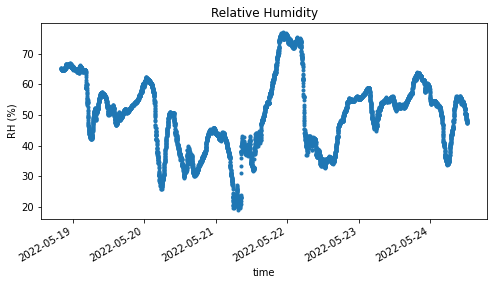

In [17]:
# %matplotlib widget

fig, ax = plt.subplots(1, figsize=(8,4))

ax.plot(df['RH'], '.')
# add labels and title
ax.set(xlabel = "time",
       ylabel = "RH (%)",
       title = "Relative Humidity")
# makes slanted dates
plt.gcf().autofmt_xdate()  

### Moving average and SavGol

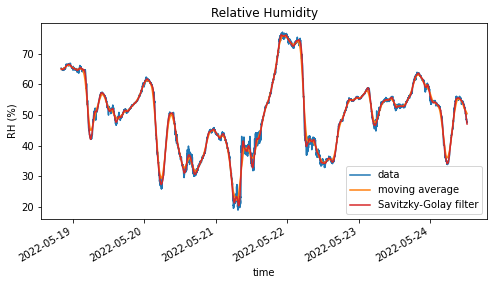

In [18]:
# %matplotlib widget

fig, ax = plt.subplots(1, figsize=(8,4))

# apply a rolling average of size "window_size",
# it can be either by number of points, or by window time
# window_size = 30  # number of measurements
window_size = '120min'  # minutes
RH_smooth = df['RH'].rolling(window_size, center=True).mean().to_frame()
RH_smooth.rename(columns={'RH': 'rolling_avg'}, inplace=True)

RH_smooth['SG'] = savgol_filter(df['RH'], window_length=121, polyorder=2)

ax.plot(df['RH'], color="tab:blue", label="data")
ax.plot(RH_smooth['rolling_avg'], color="tab:orange", label="moving average")
ax.plot(RH_smooth['SG'], color="tab:red", label="Savitzky-Golay filter")
# add labels and title
ax.set(xlabel = "time",
       ylabel = "RH (%)",
       title = "Relative Humidity")
# makes slanted dates
plt.gcf().autofmt_xdate()
ax.legend()

<!-- How does moving average work?  
![](https://e2eml.school/images/conv1d/stride_1.gif)

How does the Savitzky–Golay filter work?  
![](https://upload.wikimedia.org/wikipedia/commons/8/89/Lissage_sg3_anim.gif) -->